IMPORTS

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV

from dataset_paths import Paths


READ DATA

In [3]:
# Read the CSV file
data = pd.read_csv(Paths.CLEAN / "combined-data.csv")

# Display the first few rows of the DataFrame
data.head()


,Country,1970_co2_total,1971_co2_total,1972_co2_total,1973_co2_total,1974_co2_total,1975_co2_total,1976_co2_total,1977_co2_total,1978_co2_total,...,2012_surface_temperature,2013_surface_temperature,2014_surface_temperature,2015_surface_temperature,2016_surface_temperature,2017_surface_temperature,2018_surface_temperature,2019_surface_temperature,2020_surface_temperature,2021_surface_temperature
0,Angola,8.952570,8.538308,10.388519,11.372301,11.833761,10.930423,7.317385,12.057774,14.239234,...,0.552,1.044,0.828,1.331,1.609,0.870,1.395,1.752,1.162,1.553
1,Anguilla,0.002168,0.002168,0.002264,0.002109,0.002350,0.002584,0.002434,0.002537,0.002902,...,0.640,0.770,0.814,1.051,1.125,0.960,0.664,0.843,1.224,0.893
2,Albania,4.814516,4.814828,5.498804,4.939869,5.319746,5.414438,5.785733,6.197670,6.820001,...,1.487,1.333,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536
3,United Arab Emirates,19.437564,25.404108,27.718761,35.806205,35.971039,36.642262,45.538708,45.835847,52.580154,...,1.086,0.739,0.909,1.556,1.059,1.632,1.498,1.204,1.210,1.699
4,Argentina,88.321009,88.765100,90.716408,93.698462,93.987211,91.411464,96.029610,100.067600,99.336340,...,0.798,0.442,0.951,0.957,0.488,1.095,0.878,0.760,1.123,1.031


PROCESS DATA AND PLOT

Row averages of X: 1970_co2_total     75.329194
1971_co2_total     74.480286
1972_co2_total     78.072332
1973_co2_total     82.537992
1974_co2_total     81.152066
1975_co2_total     78.833091
1976_co2_total     83.514740
1977_co2_total     85.683968
1978_co2_total     86.685718
1979_co2_total     89.312549
1980_co2_total     87.046862
1981_co2_total     85.430878
1982_co2_total     82.930168
1983_co2_total     82.806968
1984_co2_total     85.647365
1985_co2_total     86.806041
1986_co2_total     87.348339
1987_co2_total     89.894335
1988_co2_total     93.238335
1989_co2_total     94.789704
1990_co2_total     94.260155
1991_co2_total     94.560186
1992_co2_total     95.426659
1993_co2_total     97.337732
1994_co2_total     99.949015
1995_co2_total    102.111821
1996_co2_total    105.783617
1997_co2_total    108.907761
1998_co2_total    109.408532
1999_co2_total    110.175703
2000_co2_total    113.091302
2001_co2_total    114.018392
2002_co2_total    113.910325
2003_co2_total    116.50

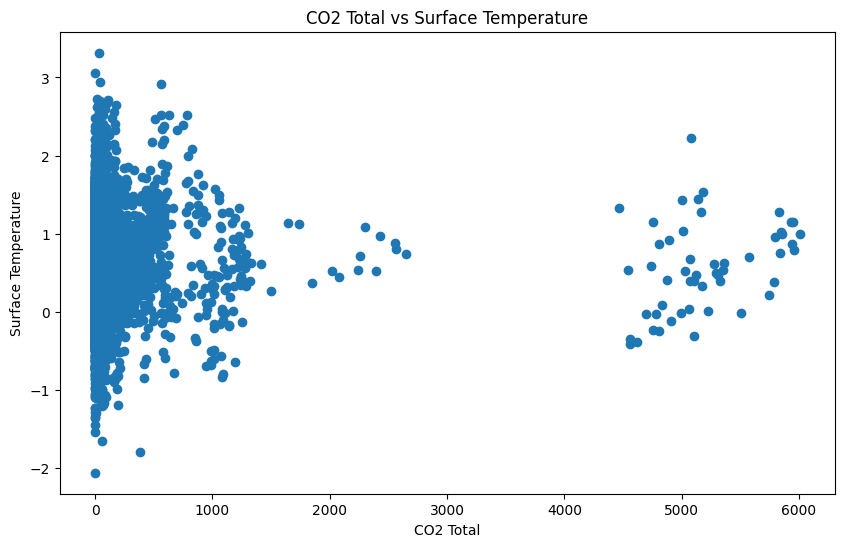

<Figure size 1000x600 with 0 Axes>

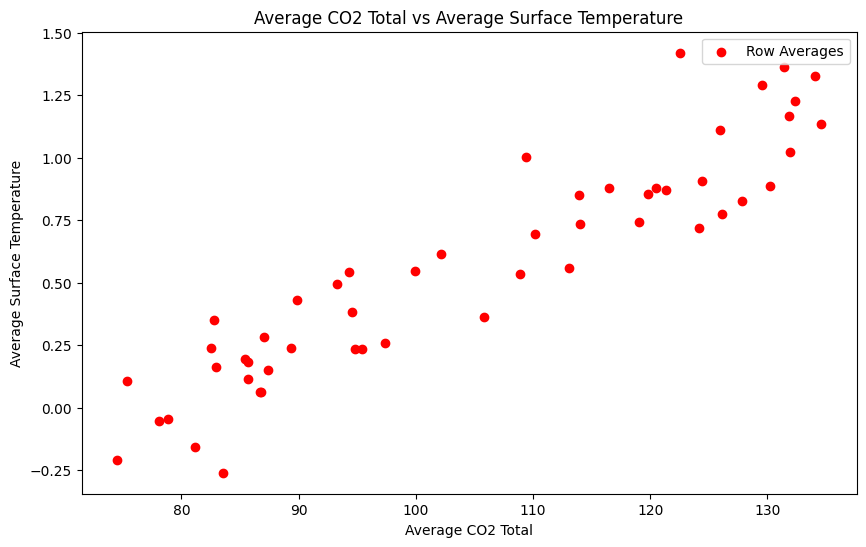

In [4]:
# Split the data into X and Y
X = data.filter(regex='co2_total')
Y = data.filter(regex='surface_temperature')
X_values = X.values.flatten()
Y_values = Y.values.flatten()

# Calculate row averages
X_column_averages = np.mean(X, axis=0)
Y_column_averages = np.mean(Y, axis=0)

print("Row averages of X:", X_column_averages)
print("Row averages of Y:", Y_column_averages)

plt.figure(figsize=(10, 6))
plt.scatter(X_values, Y_values)
plt.xlabel('CO2 Total')
plt.ylabel('Surface Temperature')
plt.title('CO2 Total vs Surface Temperature')
plt.figure(figsize=(10, 6))

# Plot the row averages
plt.figure(figsize=(10, 6))

# Plot the row averages
plt.scatter(X_column_averages, Y_column_averages, color='r', label='Row Averages')

plt.xlabel('Average CO2 Total')
plt.ylabel('Average Surface Temperature')
plt.title('Average CO2 Total vs Average Surface Temperature')

# Set the limits of the x and y axes

plt.legend()
plt.show()


TRAIN MODEL

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_column_averages, Y_column_averages, random_state=42, test_size=0.2)

X_valid = np.reshape(X_valid, (-1, 1))
X_train = np.reshape(X_train, (-1, 1))
train = lgb.Dataset(X_train, label=y_train)
valid = lgb.Dataset(X_valid, label=y_valid)

# Create a LightGBM regressor
estimator = lgb.LGBMRegressor(objective='regression', metric='l2',
                              boosting_type='gbdt', n_job=-4, device='gpu')

# Define the parameter grid
param_grid = {
    'num_leaves': [50, 100, 150],
    'learning_rate': [0.05, 0.1],
    'feature_fraction': [0.7, 0.8],
    'max_depth': [50, 100],
    'min_data_in_leaf': [30, 40],
    'bagging_fraction': [0.7, 0.8],
    'bagging_freq': [5, 10],
    'lambda_l1': [0.1, 0.2],
    'lambda_l2': [0.1, 0.2],
}

# Initialize a GridSearchCV object that will perform the hyperparameter tuning
grid = GridSearchCV(estimator, param_grid, verbose=1, cv=3, n_jobs=4)

# Perform the hyperparameter tuning on your training data
grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))


Fitting 3 folds for each of 768 candidates, totalling 2304 fits
[LightGBM] [Warning] Unknown parameter: n_job
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this war

In [6]:
parameters = {
    "objective": "regression",
    "metric": "l2",
    "boosting_type": "gbdt",
    "verbose": -1,
    "num_leaves": 50,
    "learning_rate": 0.07,
    "feature_fraction": 0.50,
}

model_lgbm = lgb.train(parameters, train, valid_sets=valid, num_boost_round=1200)


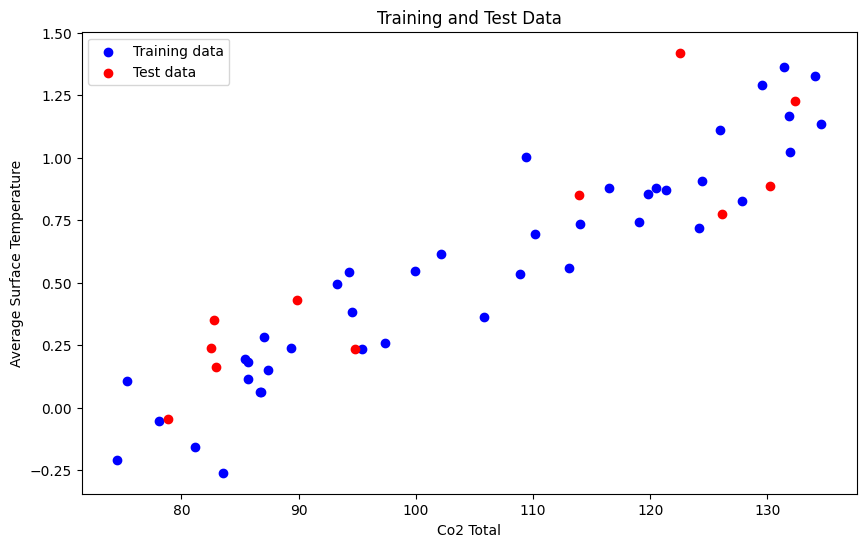

In [8]:
# Assuming your data is 1-dimensional
plt.figure(figsize=(10, 6))

# Plot the training data
plt.scatter(X_train, y_train, color='blue', label='Training data')

# Plot the test data
plt.scatter(X_valid, y_valid, color='red', label='Test data')

plt.xlabel('Co2 Total')
plt.ylabel('Average Surface Temperature')
plt.title('Training and Test Data')
plt.legend()
plt.show()


Mean squared error evalutation

In [9]:
from sklearn.metrics import mean_squared_error

# Make predictions
y_train_pred = model_lgbm.predict(X_train, num_iteration=model_lgbm.best_iteration)
y_valid_pred = model_lgbm.predict(X_valid, num_iteration=model_lgbm.best_iteration)

# Print RMSE
print('The RMSE of prediction on training set is: ', mean_squared_error(y_train, y_train_pred) ** 0.5)
print('The RMSE of prediction on validation set is: ', mean_squared_error(y_valid, y_valid_pred) ** 0.5)

from sklearn.metrics import mean_absolute_error

# Calculate the mean absolute error

print("Mean Absolute Error (MAE) on training set:", mean_absolute_error(y_train, y_train_pred))
print("Mean Absolute Error (MAE) on validation set:", mean_absolute_error(y_valid, y_valid_pred))


The RMSE of prediction on training set is:  0.23790537931153652
The RMSE of prediction on validation set is:  0.21334466879308422
Mean Absolute Error (MAE) on training set: 0.19323420934946026
Mean Absolute Error (MAE) on validation set: 0.16445493343918136


Mean Absolute Squared Error

In [10]:
# Assuming X_test is your test data
X_test = np.array([100]).reshape(-1, 1)
y_test_pred = model_lgbm.predict(X_test, num_iteration=model_lgbm.best_iteration)

print("The predicted value for:", X_test, y_test_pred[0])


The predicted value for: [[100]] 0.19745562927989357


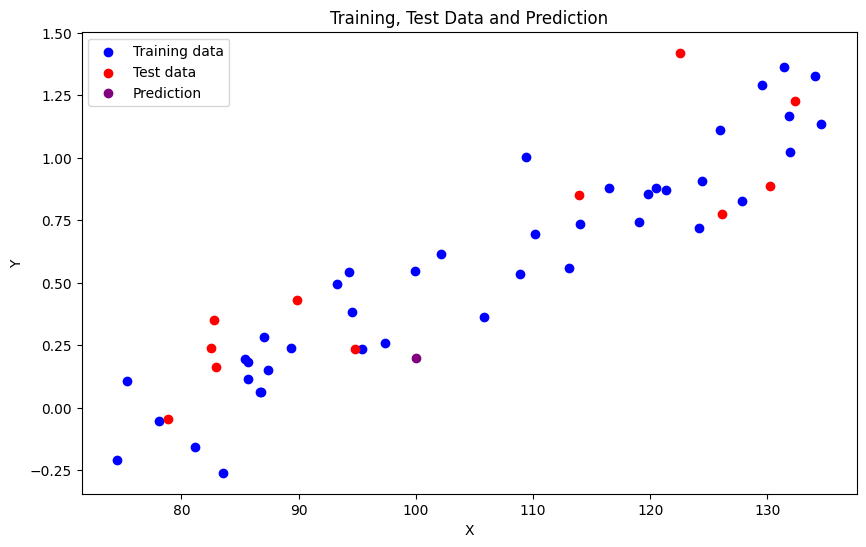

In [11]:
# Assuming your data is 1-dimensional
plt.figure(figsize=(10, 6))

# Plot the training data
plt.scatter(X_train, y_train, color='blue', label='Training data')

# Plot the test data
plt.scatter(X_valid, y_valid, color='red', label='Test data')

# Plot the prediction
plt.scatter(X_test, y_test_pred, color='purple', label='Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training, Test Data and Prediction')
plt.legend()
plt.show()


Make prediction for what the average temperature will be if the average co2 continues to rise at its current trend

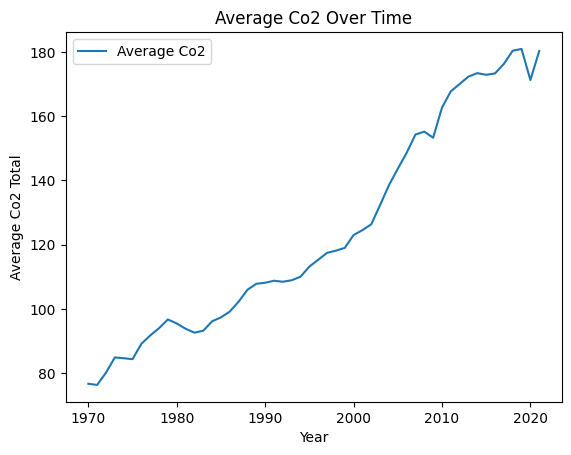

In [12]:
co2_path = Paths.CLEAN / "co2-totals.csv"


def plot_average_co2(filepath):
    # Load the CSV file
    temp = pd.read_csv(filepath)

    # Extract the X data (years)
    co2_years = temp.columns[1:].astype(int)

    # Extract the Y data (co2 for each country)
    Y = temp.set_index('Country').T

    # Calculate the average co2 for each year
    co2_mean = Y.mean(axis=1)

    # Plot the average co2
    plt.plot(co2_years, co2_mean, label='Average Co2')

    plt.xlabel('Year')
    plt.ylabel('Average Co2 Total')
    plt.title('Average Co2 Over Time')
    plt.legend()
    plt.show()


# Call the function
plot_average_co2(co2_path)


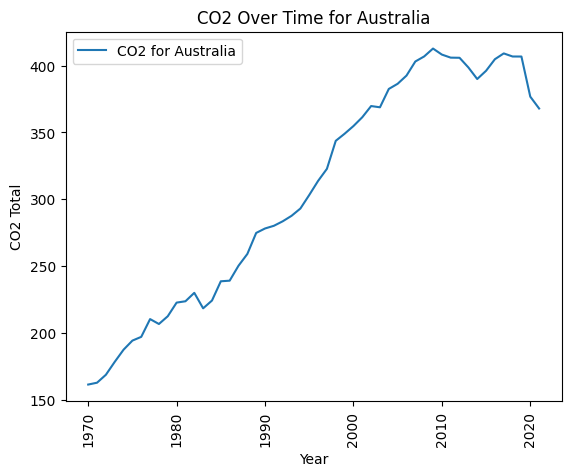

1970    161.528074
1971    162.909328
1972    168.828122
1973    178.487010
1974    187.589533
1975    194.383892
1976    197.182038
1977    210.469725
1978    206.795663
1979    212.601641
1980    222.786252
1981    223.794341
1982    230.086768
1983    218.515841
1984    224.323892
1985    238.732005
1986    239.185319
1987    250.345917
1988    259.159032
1989    274.878009
1990    278.209754
1991    280.211696
1992    283.575463
1993    287.676155
1994    293.128056
1995    303.223021
1996    313.758703
1997    322.808650
1998    343.746482
1999    349.037982
2000    354.780821
2001    361.375601
2002    369.740047
2003    368.808659
2004    382.536938
2005    386.386662
2006    392.505053
2007    403.053495
2008    406.831726
2009    412.731041
2010    408.226776
2011    405.931845
2012    405.827569
2013    398.601632
2014    389.947370
2015    396.098941
2016    404.757598
2017    409.093716
2018    406.787237
2019    406.759938
2020    376.778739
2021    367.906957
Name: Austra

In [13]:
data = pd.read_csv(Paths.CLEAN / "co2-totals.csv")
Y = data.set_index('Country').T


def plot_country_co2(country):
    # Extract the CO2 data for the given country
    country_co2 = Y[country]

    # Extract the years from the index of Y
    years = Y.index.values

    # Plot the CO2 data
    plt.plot(years, country_co2, label=f'CO2 for {country}')

    plt.xlabel('Year')
    plt.ylabel('CO2 Total')
    plt.title(f'CO2 Over Time for {country}')
    plt.legend()

    # Adjust the x-axis ticks to only show labels for every 10th year
    plt.xticks(years[::10], rotation=90)

    plt.show()
    return country_co2


plot_country_co2('Australia')


In [14]:
data = pd.read_csv(Paths.CLEAN / "co2-totals.csv")
Y = data.set_index('Country').T


#predict co2 for a country by year
def predict_co2_lgbm(country, year):
    # Define the years for which you have CO2 data
    co2_years = Y.index.values.reshape(-1, 1).astype(np.float64)

    # Extract the CO2 data for the given country
    country_co2 = Y[country]

    # Split the data into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(co2_years, country_co2,
                                                          test_size=0.2, random_state=42)

    # Create a LGBM Regressor object
    model = lgb.LGBMRegressor()

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = model.predict(X_valid)

    # The mean squared error
    print('Mean squared error: %.2f' % mean_squared_error(y_valid, y_pred))

    # Use the model to predict the CO2 level for the given year
    prediction = model.predict(np.array([[float(year)]]))

    return prediction[0]


print(predict_co2_lgbm('Ireland', 2000))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 41, number of used features: 1
[LightGBM] [Info] Start training from score 35.280972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [15]:
#predict the surface temperature for a country by year
def predict_temp_by_year(country, year):
    # Assuming X_test is your test data
    X_test = predict_co2_lgbm(country, year)
    print("the co2 levels will be ", X_test, "for the year", year, "in", country)
    y_test_pred = model_lgbm.predict(X_test, num_iteration=model_lgbm.best_iteration)
    print("The predicted value for:", year, y_test_pred[0])
    print(X_test)
    return y_test_pred[0]


predict_temp_by_year('Ireland', 2050)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 41, number of used features: 1
[LightGBM] [Info] Start training from score 35.280972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

C:\Users\darra\Projects\pycharm\e3\.venv\Lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.19745562927989357